<a href="https://colab.research.google.com/github/Vakurin/GANs-On-TensorFlow-2/blob/master/Second_GAN_DCGAN(Deep_Convolution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline
---
Main Topics Of This File:
* Batch Normalization
* Convolitional Layers(Conv2DTransp)

## Import Libs

In [0]:
# To generate GIFs
!pip install -q imageio

In [2]:
# Make default version tf2.0 in colab
%tensorflow_version 2.x 

import tensorflow as tf
print(tf.__version__)
keras = tf.keras

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython import display
import glob
import imageio
import PIL

tf.config.experimental_run_functions_eagerly(True)

TensorFlow 2.x selected.
2.1.0


tf.function и AutoGraph работают, генерируя код и копируя его в графы TensorFlow. Этот механизм пока не поддерживает пошаговые отладчики, такие как pdb. Однако вы можете вызвать **`tf.config.run_functions_eagerly(True)`** временно включить eager execution внутри tf.function и использовать ваш любимый отладчик:

## Build Generator with Conv and Batch
* Conv2DTranspose - A transposed convolution essentially has a stride of less than one, such that the output dimensions are larger than the input dimension.
* I'll note that if you **use a kernel for conv2d, then use the same kernel for conv2d_transpose, you get the original image back.** You don't have to transpose the kernel.


In [0]:
def model_generator(z_dim=100):
  
  model = keras.models.Sequential(name='Generator')
  
  # Take a random noisy vector and reshape it in Tensor 
  model.add(keras.layers.Dense(256 * 7 * 7, use_bias=False, input_shape=(z_dim, )))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU(alpha=0.01))
  model.add(keras.layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)
  
  # 7x7x256 (Conv2D with stride=1) -> 7x7x128
  model.add(keras.layers.Conv2DTranspose(128, kernel_size=(5, 5), use_bias=False, strides=1, padding='same', name='First_Conv2DTrans'))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU(alpha=0.01))

  # Conv2D With Stride 1 Make a same height and width  14x14x128 -> 14x14x64
  model.add(keras.layers.Conv2DTranspose(64, kernel_size=(5, 5), use_bias=False, strides=2, padding='same', name='SecondConv2DTrans'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU(alpha=0.01))
  
  # 14x14x64 -> 28x28x1
  model.add(keras.layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=2, use_bias=False, padding='same', activation='tanh', name='Conv2D'))
  assert model.output_shape == (None, 28, 28, 1)
  
  return model

### Generated Image On Untrained Model 

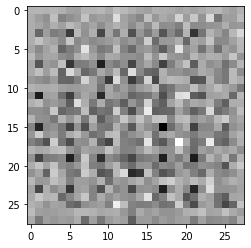

In [9]:
generator = model_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray');

### Generator Summary

In [10]:
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
First_Conv2DTrans (Conv2DTra (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0 

## Build Disriminator
* If we don't using `padding='same' and stride=2` we got 28x28 -> 12x12

* **Model:**
28x28x1 -> 14x14x32 -> 7x7x64 -> 4x4x128 -> 2048 -> 1(prediction)

In [0]:
def model_discriminator(input_shape=(28, 28, 1)):
  model = keras.Sequential(name='Discriminator')
  
  model.add(keras.layers.Conv2D(64, 
                                kernel_size=5, 
                                strides=2,
                                padding='same',
                                input_shape=input_shape))
  model.add(keras.layers.LeakyReLU(alpha=0.01))
  model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Conv2D(128, 
                                kernel_size=5,
                                strides=2,
                                padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.01))
  model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Flatten())
  # Prediction Layer Fake or Not
  # Without activation layer
  model.add(keras.layers.Dense(1, name='Discriminator_Output'))

  return model

### Use Untrained Model
The model will be trained to output positive values for real images, and negative values for fake images. 

In [12]:
discriminator = model_discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0049836]], shape=(1, 1), dtype=float32)


### Discriminator Summary

In [13]:
model_discriminator().summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)            

## Define the loss and optimizer
Define loss functions and optimizers for both models.

* **Cross Entropy** Function Can Get Two Arguments `y_true, y_pred` 

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

### D Loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### G Loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

## Save Checkpoint

In [0]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define Training Loop

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

## Gradient Tape 
If at any point, we want to use multiple variables in our calculations, all we need to do is give tape.gradient a list or tuple of those variables. When we optimize Keras models, we pass model.trainable_variables as our variable list.

If you want easier access to the gradients and loss as well as a clearer understanding of the training it might be worth to use tf.GradientTape instead of the fit method.

Using GradientTape, one can manually define each training step in the training procedure. The basic steps include:

* Forward pass
* Calculating loss
* Backward pass
* Updating the gradients

**For image classification GradientTape could be used like in the following example:**

```
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
```

Article About Gradient Tape:
https://medium.com/analytics-vidhya/tf-gradienttape-explained-for-keras-users-cc3f06276f22

In [6]:
a = tf.Variable(6.0, trainable=True)

with tf.GradientTape(persistent=True) as tape:
    y1 = a ** 3 #(a ** 2) * 3
    y2 = a ** 2 #(a ** 1) * 2
# Тут считаем дифференцирование                                                                                                                                                                                                                                                                                                                                                 
print(tape.gradient(y1, a).numpy())
print(tape.gradient(y2, a).numpy())

108.0
12.0


* `@tf.function` будет скомпилирована в граф, что означает, что вы получаете преимущества более быстрого выполнения, запуска на GPU или TPU

* `GradientTape` автоматическое компилирование диффиренцалов

* `tf.gradient` - **arguments** 
`target:` a list or nested structure of Tensors or Variables to be differentiated.
`sources:` a list or nested structure of Tensors or Variables. target will be differentiated against elements in sources.)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.



In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

@tf.function
def train_step(images):
    noise = tf.random.normal([256, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Load Train Data And Preproccesing
* `tf.data.Dataset.from_tensor_slices` - split data on single arrays, after that shuffle  

In [0]:
(train_images, train_labels), (_, _) = keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Number of images
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Training

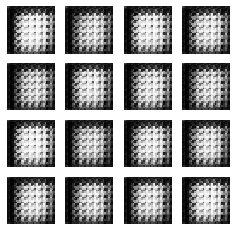

Time for epoch 1 is 17.528711795806885 sec
G Loss: tf.Tensor(0.7516539, shape=(), dtype=float32)
D Loss: tf.Tensor(1.2672596, shape=(), dtype=float32)
G Loss: tf.Tensor(0.75615, shape=(), dtype=float32)
D Loss: tf.Tensor(1.2415392, shape=(), dtype=float32)
G Loss: tf.Tensor(0.7690507, shape=(), dtype=float32)
D Loss: tf.Tensor(1.1750605, shape=(), dtype=float32)
G Loss: tf.Tensor(0.7778958, shape=(), dtype=float32)
D Loss: tf.Tensor(1.1393027, shape=(), dtype=float32)
G Loss: tf.Tensor(0.778775, shape=(), dtype=float32)
D Loss: tf.Tensor(1.1342254, shape=(), dtype=float32)
G Loss: tf.Tensor(0.8142409, shape=(), dtype=float32)
D Loss: tf.Tensor(1.023952, shape=(), dtype=float32)
G Loss: tf.Tensor(0.8313675, shape=(), dtype=float32)
D Loss: tf.Tensor(1.0033886, shape=(), dtype=float32)
G Loss: tf.Tensor(0.866339, shape=(), dtype=float32)
D Loss: tf.Tensor(0.953012, shape=(), dtype=float32)
G Loss: tf.Tensor(0.9216063, shape=(), dtype=float32)
D Loss: tf.Tensor(0.92087805, shape=(), dtype

KeyboardInterrupt: ignored

In [31]:
train(train_dataset, EPOCHS)

## Create Gif

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

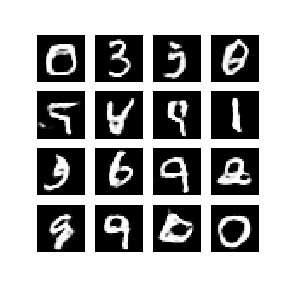

In [82]:
display_image(EPOCHS)

In [0]:
anim_file = 'dcgan_dropout.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6, 2, 0, ''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)